# HarvestStat Data Profiling - Lesotho

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32635' # Lesotho
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/LS_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Lesotho',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionfacts/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1980	 | LS1980A1 | 10	| nan	| 0	| nan	| 0	|
----------------------------------------------- #


In [3]:
#4. Combine production systems
# Starting in ~2019, the data is split into a bunch of different production systems. We want to combine these
# into a single production system and rename it to be consistent with the older data
for ixSY in df.season_year.unique():
    for ixC in df.loc[((df.season_year==ixSY)),'product'].unique():
        for ixA1 in df.loc[((df.season_year==ixSY)&(df['product']==ixC)),'admin_1'].unique():
            ap = np.nan
            ah = np.nan
            pr = np.nan
            for ixPS in df.loc[((df.season_year==ixSY)&(df['product']==ixC)&(df.admin_1==ixA1)),'crop_production_system'].unique():
                if (ixPS!=ixPS)|(ixPS=='All (PS)'):continue 
                #check for both planted area and production. It's never harvested area w/o planted area in LS
                ixLoc = ((df.season_year==ixSY)&(df['product']==ixC)&(df.admin_1==ixA1)&(df.crop_production_system==ixPS))
                iap = df.loc[(ixLoc)&((df.indicator=='Area Planted'))].value
                iah = df.loc[(ixLoc)&((df.indicator=='Area Harvested'))].value
                ipr = df.loc[(ixLoc)&(df.indicator=='Quantity Produced')].value
                if ((np.size(iap)+np.size(ipr)==2)&np.sum(np.isfinite(iap)+np.isfinite(ipr))==2):
                    ap = np.nansum([ap,iap])
                    pr = np.nansum([pr,ipr])
                    if (np.size(iah)>0)&(np.isfinite(iah)): ah = np.nansum([ah,iah])
                idah = pd.DataFrame(df.loc[ixLoc&(df.indicator=='Area Harvested')])
                idap = pd.DataFrame(df.loc[ixLoc&(df.indicator=='Area Planted')])
                idpr = pd.DataFrame(df.loc[ixLoc&(df.indicator=='Quantity Produced')])
                idyl = pd.DataFrame(df.loc[ixLoc&(df.indicator=='Yield')])
                df = df.loc[~ixLoc] #remove if there is not both prior to aggregating
            idah['crop_production_system'] = 'All (PS)'
            idap['crop_production_system'] = 'All (PS)'
            idpr['crop_production_system'] = 'All (PS)'
            idyl['crop_production_system'] = 'All (PS)'

            idah['value'] = ah
            idap['value'] = ap
            idpr['value'] = pr
            idyl['value'] = pr/ap
            
            df = df.append(idah).append(idap).append(idpr).append(idyl)

In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_1'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])
# 3. Remove duplicate data 
pub_name_remove = 'BOS, Lesotho, Statisitical Report, 2017/2018 Crop Forecasting Report, NO 21 of 2040'
df = df[df['publication_name'] != pub_name_remove]

#4. Combine production systems
# Starting in 2019, the data is split into a bunch of different production systems. We want to combine these
# into a single production system and rename it to be consistent with the older data
#for ixPS in df.crop_production_system.unique():
#    for ixSY in df.season_year.unique():
#        for ixC in df['product'].unique():
#            for ixA1 in df.admin_1.unique():
#                #check for both planted area and production. It's never harvested area w/o planted area in LS
#                ixLoc = ((df.season_year==ixSY)&(df['product']==ixC)&(df.admin_1==ixA1)&(df.crop_production_system==ixPS))
#                if (np.nansum(df.loc[(ixLoc)&((df.indicator=='Area Planted'))].value)+
#                    np.nansum(df.loc[(ixLoc)&(df.indicator=='Quantity Produced')].value))==2: continue
#                else:
#                    df = df.loc[~ixLoc] #remove if there is not both prior to aggregating

# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([LS_Admin1_1980], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 17,332
Removed 11,391 "Missing Value" points
99/4,333 "Area Harvested" points are retained.
2,039/4,333 "Area Planted" points are retained.
1,903/4,333 "Quantity Produced" points are retained.
1,900/4,333 "Yield" points are retained.
Current data points: 5,941

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1981 - 2022
8 grain types are found: Barley (Unspecified), Beans (mixed), Maize (Corn), Maize Grain (White), Oats (Unspecified), Pea (unspecified), Sorghum, Wheat Grain
2 seasons are found: Winter (07-01), Summer (01-01)
2 crop production system are found: none, All (PS)
Data sources include:
[1] Bureau of Statistics, Lesotho --- Agricultural Production Survey Crops, Lesotho
[2] Bureau of Statistics, Lesotho --- Agricultural Statistical Report, Lesotho
[3] Bureau of Statistics, Lesotho --- Statistical Yearbook, Lesotho
Administrative-1 fnids: 10


- Lesotho crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-lesotho.png?itok=rDGlnOwG" width=900><br>

<img src="https://ipad.fas.usda.gov/countrysummary/images/LT/cropcalendar/safrica_lt_calendar.png" width=900>

- FDW data consists of `LS1980A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1980	 | `LS1980A1` | 10	| -	| -	|

- Comparison between admin boundaries.

<img src="../figures/LS_admin_shapes.png" width=900>

- **`LS1980A1`** is used to represent current admin-level 1 crop data.
- Lesotho has 2 crop seasons: `Summer (08-01)` and `Winter (02-01)`.
- Lesotho has 5 crop production system: `none`, `Mountains (PS)`, `Foothills (PS)`, `All (PS)`, `Senqu River Valley (PS)`.
- Lesotho has no population group.

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = LS_Admin1_1980.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area_new, prod_new = FDW_PD_Compiling(df, shape_used)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_LS.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [country, season_name] are in the external season calendar.
../data/crop/adm_crop_production_LS.csv is saved.


## Visualization of production data

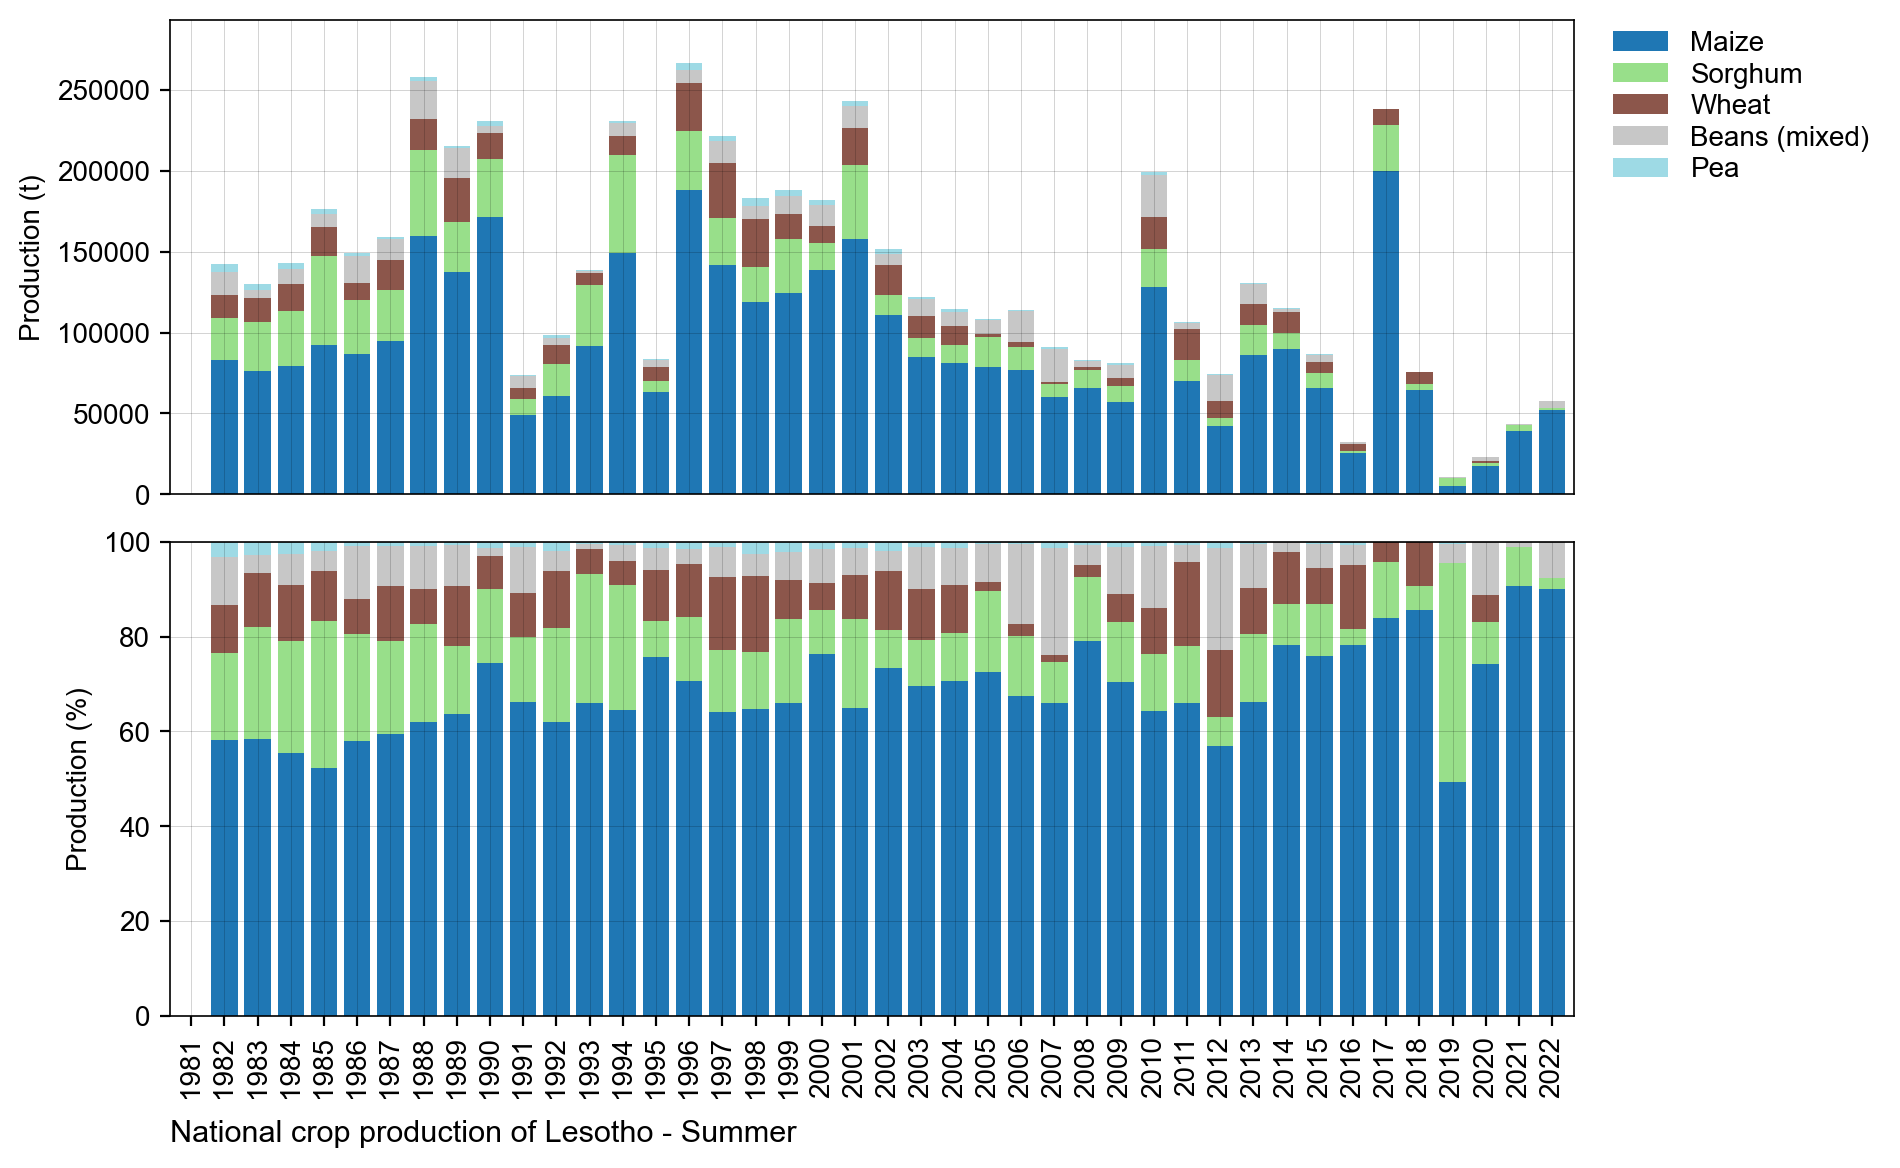

../figures/LS_bar_natgrainprod_Summer.png is saved.


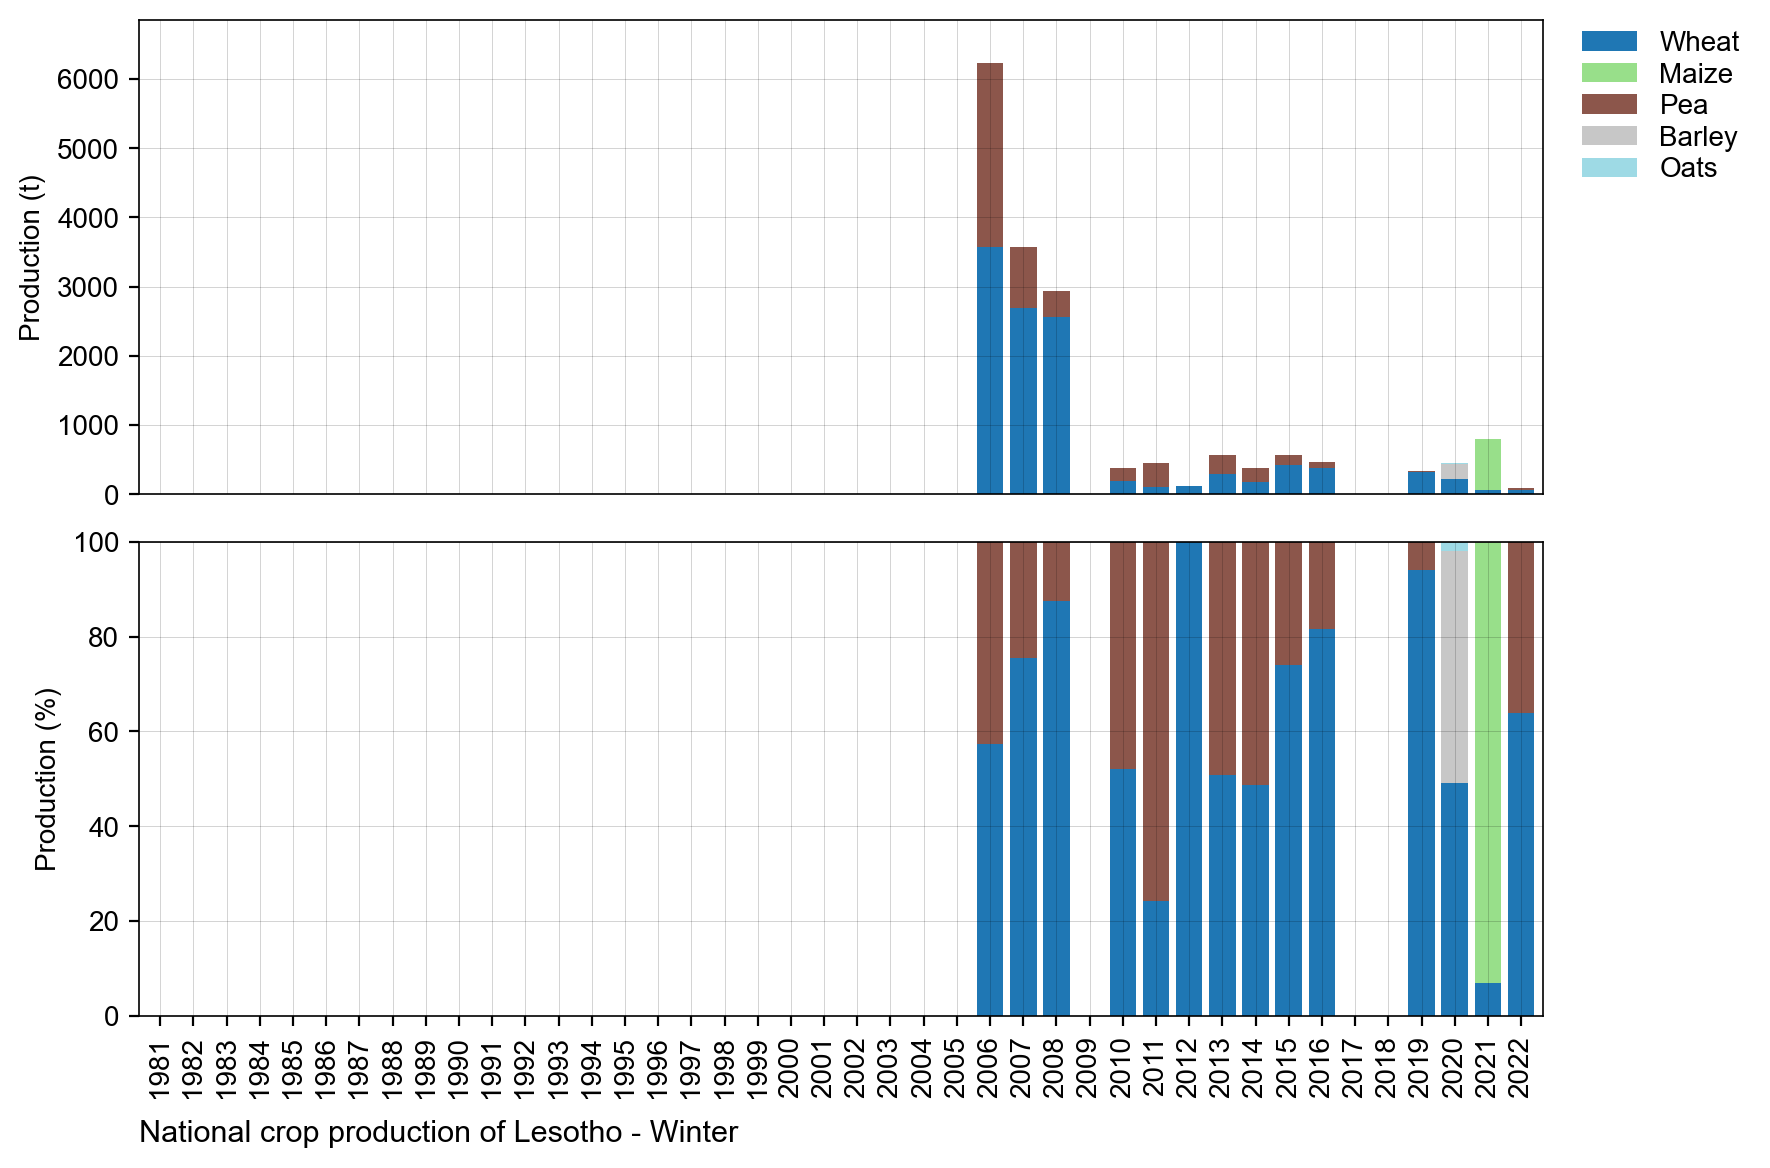

../figures/LS_bar_natgrainprod_Winter.png is saved.


In [7]:
# Bar chart of national crop production
country_iso, country_name = 'LS', 'Lesotho'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize','Sorghum','Wheat']
for season_name in ['Summer','Winter']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

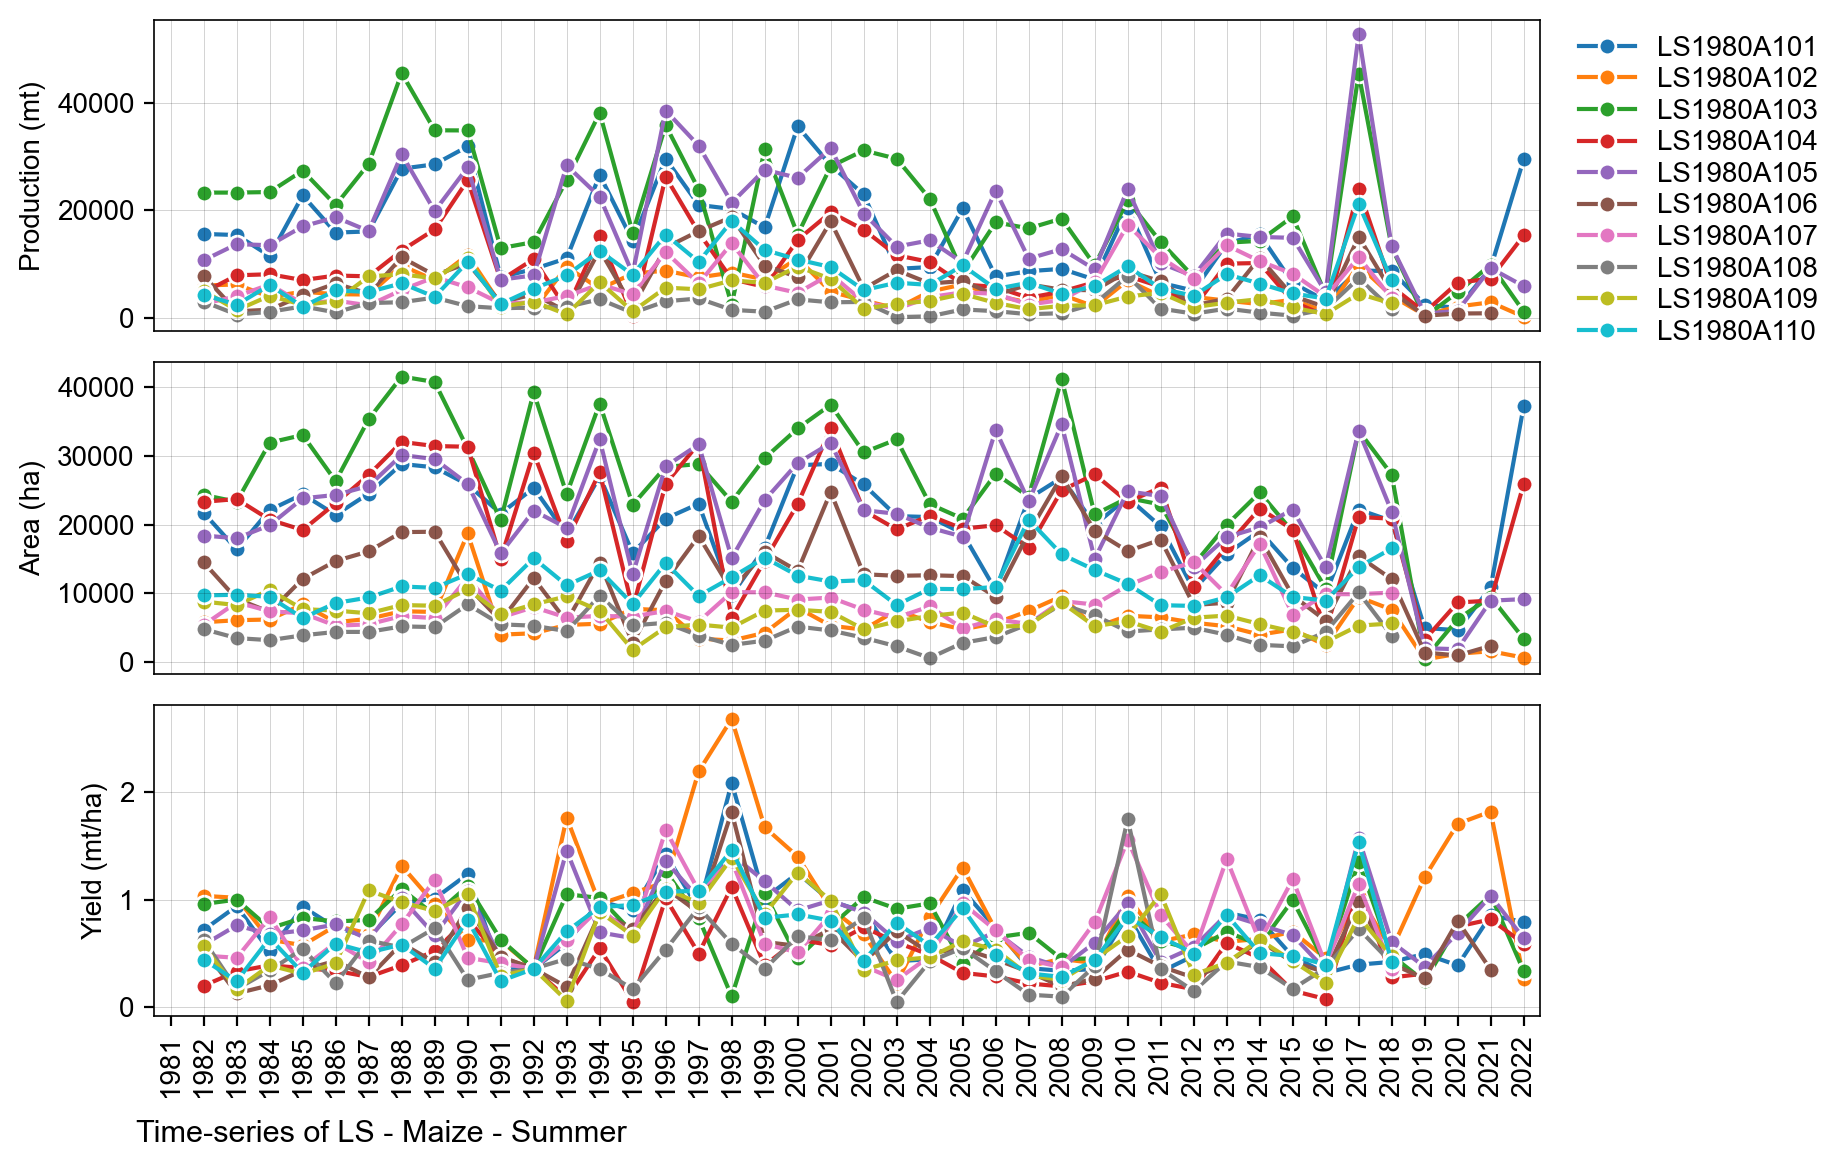

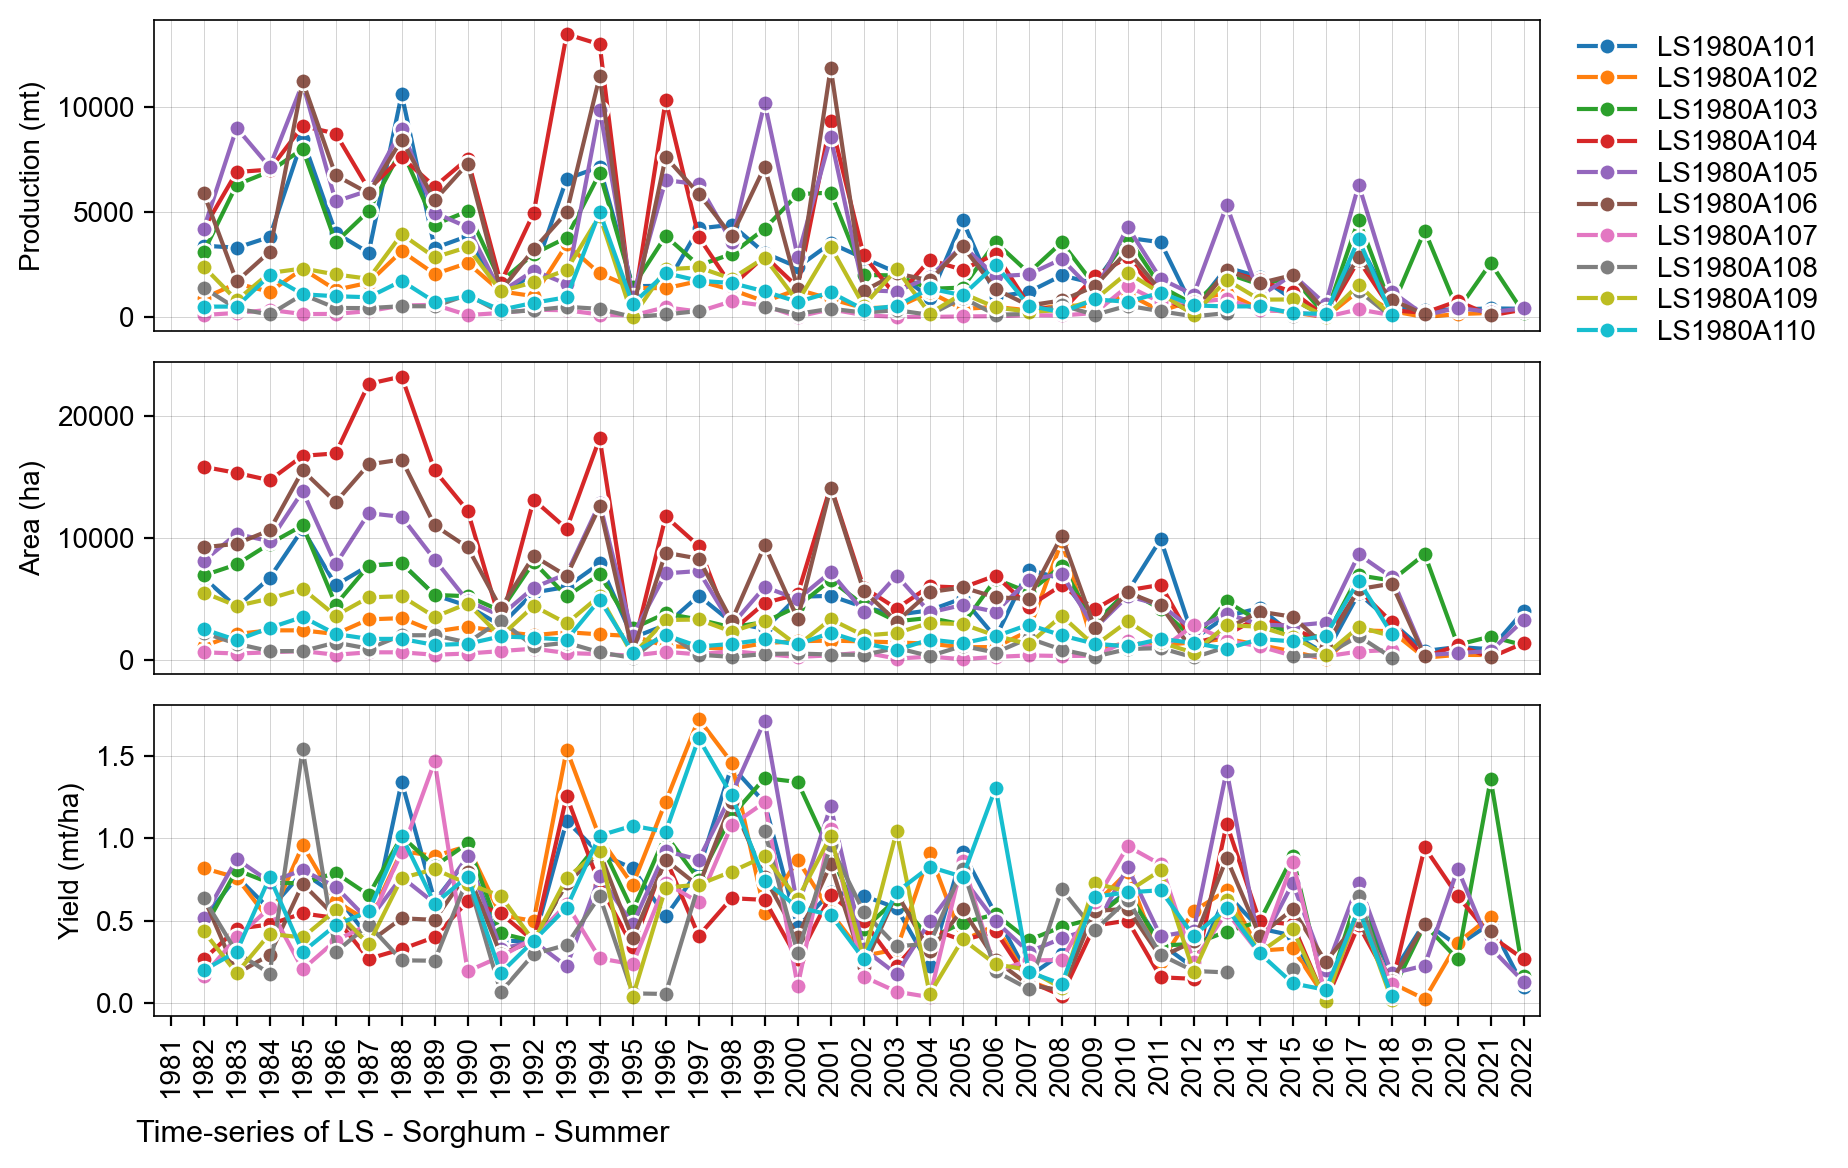

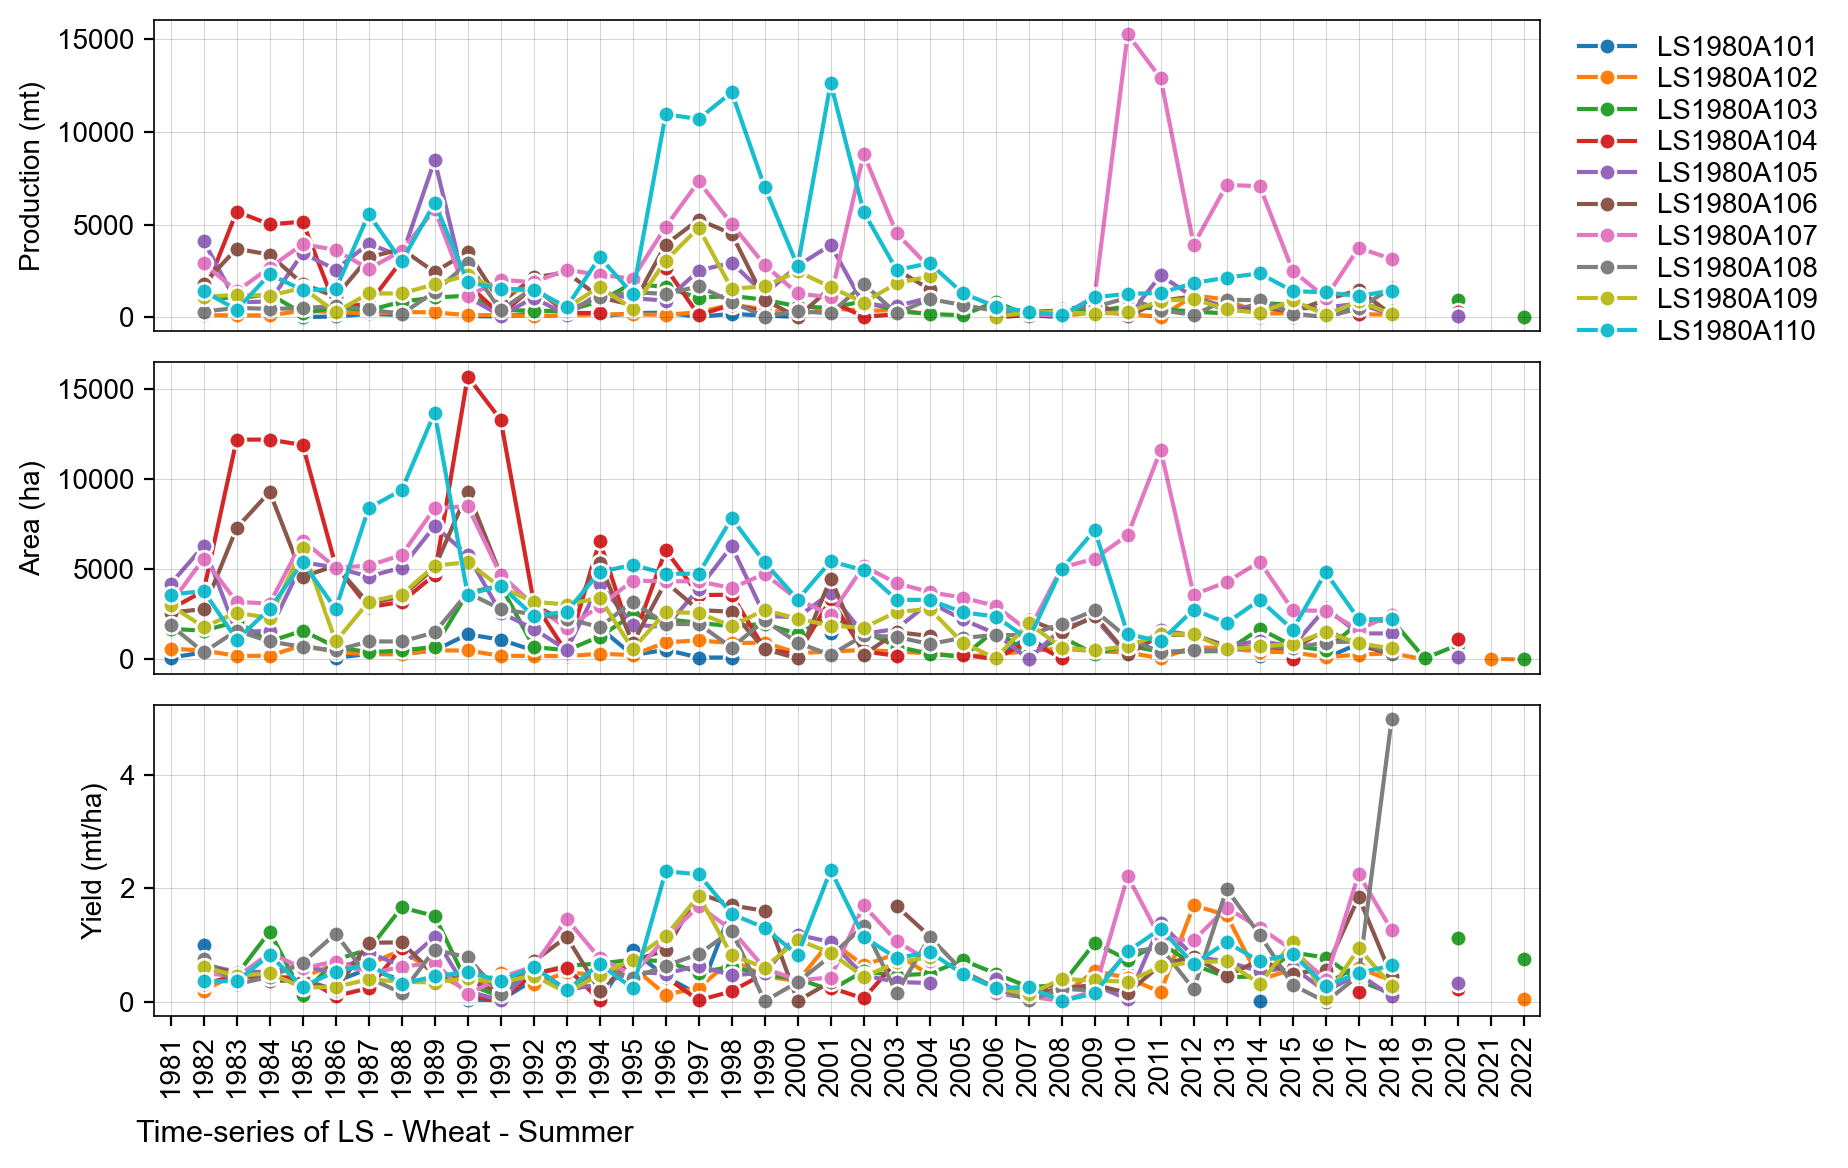

In [8]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'LS', 'Lesotho'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Summer'],
    ['Sorghum','Summer'],
    ['Wheat','Summer'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)